In [2]:
import numpy as np
from scipy import ndimage as ndi
from scipy import signal as sig
%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
image =  np.array([[1, 2, 3, 4, 5, 6, 7, 8 ],
                   [2, 3, 4, 5, 6, 7, 8, 9],
                   [3, 4, 5, 6, 7, 8, 9, 10],
                   [4, 5, 6, 7, 8, 9, 10, 11],
                   [5, 6, 7, 8, 9, 10, 11, 12],
                   [6, 7, 8, 9, 10, 11, 12, 13]])

image = np.zeros((10,10))
image[5,5] = 4;  image[2,7] = 1; image[8,6] = 1; image[9,2] = 1; image[1,2] = 1

# even weighting
fp_even = np.ones((9,9))

# mask
mask = image.astype(bool)
mask[0:4,] = True


In [5]:
# Size of square neighbourhood for weighting (recommend choosing odd values)
size = 9
# If neighbourhood size is an even number
if (size % 2) == 0:
    # method for sequence when size is even
    lr = np.r_[0:1:size/2j]
    hor = np.concatenate([lr, np.flipud(lr)])
else:
    # method for sequence when size is odd
    hor = abs( abs(np.mgrid[-1:1:size/1j]) - 1 )
# weights array    
xw,yw = np.meshgrid(hor, hor.T)
weights = xw * yw



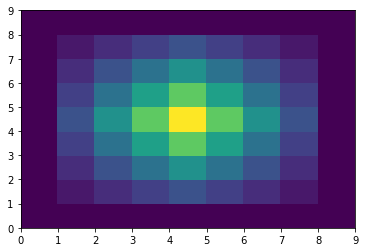

In [4]:
# plot
plt.pcolormesh(weights)

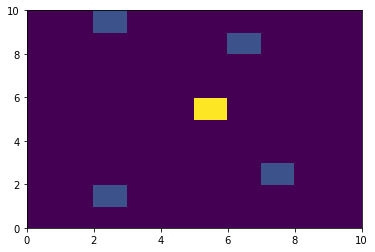

In [8]:
plt.pcolormesh(image)

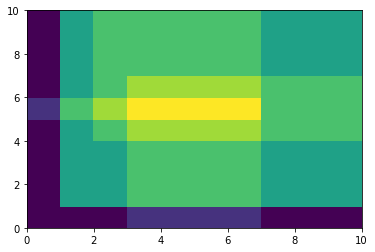

In [6]:
#%timeit ndi.convolve(image, fp, mode='constant', cval=0)
test1 = ndi.convolve(image, fp_even, mode='constant', cval=0)
plt.pcolormesh(test1)


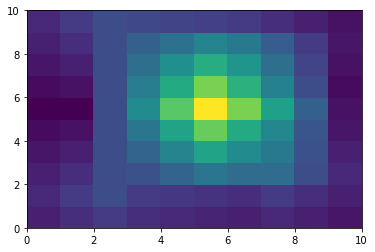

In [9]:
test2 = ndi.convolve(image, weights, mode='constant', cval=0)
plt.pcolormesh(test2)


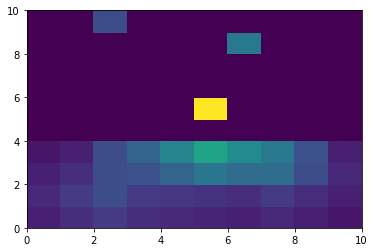

In [20]:
mask_image = test2 * mask
plt.pcolormesh(mask_image)

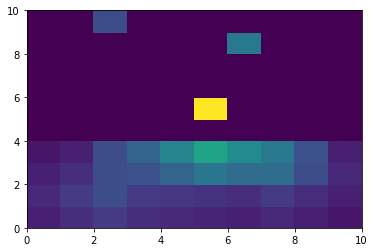

In [25]:
mask_image = np.multiply(test2,mask)
plt.pcolormesh(mask_image)


In [8]:
from multiprocessing import Queue
import threading
import time

def smooth_img(q,im,w):
    im_stack_tmp = ndi.convolve(im, w, mode='constant', cval=0)
    q.put(im_stack_tmp)

start = time.time()
single = ndi.convolve(image, weights, mode='constant', cval=0)
print('single thread: ' + str(time.time()-start))


start = time.time()
q = Queue()
t = threading.Thread(target=smooth_img, args = (q,image,weights))
t.daemon = True
t.start()
multi = q.get()
print('multi thread: ' + str(time.time()-start))

single thread: 0.00025177001953125
multi thread: 0.05022931098937988


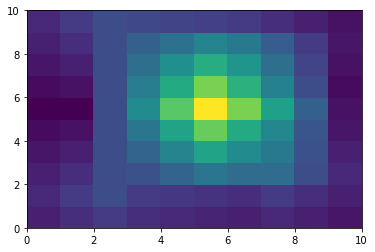

In [10]:
plt.pcolormesh(single)

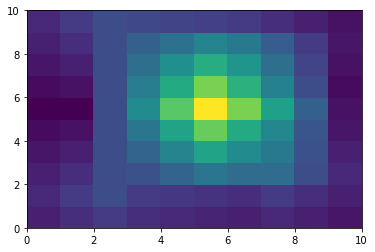

In [11]:
plt.pcolormesh(multi)

In [30]:
# %timeit ndi.generic_filter(image, np.sum, footprint=fp, mode='constant', cval=0)
# test1 = ndi.generic_filter(image, np.sum, footprint=fp, mode='constant', cval=0)
# test1


225 µs ± 5.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([[ 14,  23,  32,  41,  50,  59,  59,  48],
       [ 23,  37,  50,  62,  74,  86,  88,  69],
       [ 32,  50,  65,  78,  91, 104, 106,  85],
       [ 41,  62,  78,  91, 104, 117, 118,  94],
       [ 43,  66,  82,  94, 106, 118, 117,  89],
       [ 36,  53,  67,  76,  85,  94,  89,  70]])

In [28]:
#%timeit ndi.convolve(image, fp, mode='constant', cval=0)
test2 = ndi.convolve(image, fp, mode='constant', cval=0)
test2

21.4 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


array([[ 14,  23,  32,  41,  50,  59,  59,  48],
       [ 23,  37,  50,  62,  74,  86,  88,  69],
       [ 32,  50,  65,  78,  91, 104, 106,  85],
       [ 41,  62,  78,  91, 104, 117, 118,  94],
       [ 43,  66,  82,  94, 106, 118, 117,  89],
       [ 36,  53,  67,  76,  85,  94,  89,  70]])

In [38]:
%timeit sig.oaconvolve(image, fp, mode='same')
test3 = sig.oaconvolve(image, fp, mode='same')
test3

103 µs ± 3.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


array([[ 14.,  23.,  32.,  41.,  50.,  59.,  59.,  48.],
       [ 23.,  37.,  50.,  62.,  74.,  86.,  88.,  69.],
       [ 32.,  50.,  65.,  78.,  91., 104., 106.,  85.],
       [ 41.,  62.,  78.,  91., 104., 117., 118.,  94.],
       [ 43.,  66.,  82.,  94., 106., 118., 117.,  89.],
       [ 36.,  53.,  67.,  76.,  85.,  94.,  89.,  70.]])

In [11]:
import numba
from numba import cfunc, carray
from numba.types import intc, CPointer, float64, intp, voidptr
from scipy import LowLevelCallable

def jit_filter_function(filter_function):
    jitted_function = numba.jit(filter_function, nopython=True)
    @cfunc(intc(CPointer(float64), intp, CPointer(float64), voidptr))
    def wrapped(values_ptr, len_values, result, data):
        values = carray(values_ptr, (len_values,), dtype=float64)
        result[0] = jitted_function(values)
        return 1
    return LowLevelCallable(wrapped.ctypes)

@jit_filter_function
def fmin(values):
    result = np.inf
    for v in values:
        if v < result:
            result = v
    return result

In [15]:
%timeit ndi.generic_filter(image, fmin, footprint=fp)


18.7 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
